# Load and Cleaning Data

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('datasets/tsdm.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77232 entries, 0 to 77231
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   PADDOCK_ID          77232 non-null  object 
 1   OBSERVATION_DATE    77232 non-null  object 
 2   TSDM                77232 non-null  float64
 3   15D_AVG_DAILY_RAIN  77232 non-null  float64
 4   15D_AVG_MAX_TEMP    77232 non-null  float64
 5   15D_AVG_MIN_TEMP    77232 non-null  float64
 6   15D_AVG_RH_TMAX     77232 non-null  float64
 7   15D_AVG_RH_TMIN     77232 non-null  float64
 8   15D_AVG_EVAP_SYN    77232 non-null  float64
 9   15D_AVG_RADIATION   77232 non-null  float64
dtypes: float64(8), object(2)
memory usage: 5.9+ MB


In [3]:
print(df['PADDOCK_ID'].value_counts())

PADDOCK_ID
c7915038a9a992caf85b851b7431e7c072e539c4cb69219b7b443a8d0b6c649a    143
05f8855dc89829d1e7dd08874d78f7e754868869a7c4ac173182c2d0114b1282    143
212b691e40bf4bb46b975233b49d55653f1b8bf23b707e2c771d73d807831efb    143
f31c983470b9b008a3f0ceefb39b6a00c9e437e6efb1fb383de4cb240e5b5af8    143
8c5a445288435e7781b937d479b5562b0b866ca326eb4d87f47988a98a5e41cf    143
                                                                   ... 
aaff392e5f7e09710178426cf252b81148c59097c5c799111d1fa802a88f7c2a    136
754055a349cf50ee526d53ae88a91c11612eaeb15b3abad8fa26cf391058d7e8    136
c78ba55c85fe96b4fb11c2575a5517c91e18c91ec0d780d3960d8db50dc80fcc    135
c33da551c83521e2eb82d63ea61fada7a833c8b105986bc148cae009cc49e5fa    135
9a34031609b7c59566de10be9542e96f5533772a95f26bd7cdbda844e61bcecb    135
Name: count, Length: 547, dtype: int64


In [4]:
def create_sequences(sequence, lookback, forecast_horizon, target_col):
    T, num_features = sequence.shape
    X, y, lengths = [], [], []
    pad_vector = np.zeros((lookback, num_features))

        # Fixed-length lookback with pre-padding
    for t in range(1, T - forecast_horizon + 1):
        context = sequence[:t]
        if len(context) > lookback:
            context = context[-lookback:]

        padded_context = pad_vector.copy()
        padded_context[-len(context):] = context

        X.append(padded_context)
        y.append(sequence[t:t + forecast_horizon, target_col])
        lengths.append(min(len(context), lookback))

    return np.array(X), np.array(y), lengths

5. Inside create_sequences(...):

Purpose: Generate training samples of fixed-length input sequences and corresponding future targets.
Steps Explained:
Use a sliding window approach over the time series.
For each time step t, look back up to lookback steps.
If not enough data, pad with zeros to maintain fixed length.
The target is the forecast_horizon (6 steps) ahead from t.
Why These Are Necessary:

LSTM requires fixed-length sequences for training.
Padding ensures all sequences are the same length (lookback = 10), allowing efficient batching.
Output labels (y) are multi-step forecasts (6 steps), suitable for sequence-to-sequence prediction.

In [6]:
import numpy as np
import torch

def data_prep(df, feature_columns, lookback, test_steps, target_col):
    # Prepare to store all training data
    X_all, y_all = [], []
    paddock_ids = []  # To track which location each sample comes from
    test_data = []  # To store test data for each location
    train_data = []
    lengths_all = []  # To store the lengths of each sequence for packing

    # Process each location's data
    for paddock_id, group in df.groupby('PADDOCK_ID'):
        feature_values = group[feature_columns].values

        if len(feature_values) < 143:
            continue
            
        # Separate the last 12 steps for testing
        # Scale the data
        scaler = StandardScaler()
        train_sample = scaler.fit_transform(feature_values[:-test_steps])
        test_sample = scaler.transform(feature_values[-test_steps:])
        
        train_data.append((paddock_id, train_sample))
        test_data.append((paddock_id, test_sample, scaler))  # Store test data and scaler

        # Prepare LSTM sequence data for training
        X_paddock, y_paddock, lengths = create_sequences(train_sample, lookback, test_steps, target_col)

        # Append to the overall dataset
        X_all.append(X_paddock)
        y_all.append(y_paddock)
        lengths_all.append(lengths)  # Store sequence lengths
        # Store Location ID for tracking
        paddock_ids.extend([paddock_id] * len(y_paddock))

    # Concatenate all locations' training data for model training
    X_all = np.concatenate(X_all, axis=0)
    y_all = np.concatenate(y_all, axis=0)
    lengths_all = np.concatenate(lengths_all, axis=0)  # Concatenate sequence lengths

    # Reshape X to be [samples, time steps, features] as required by LSTM
    X_all = X_all.reshape((X_all.shape[0], X_all.shape[1], X_all.shape[2]))  
    
    
    return torch.Tensor(X_all), torch.Tensor(y_all), torch.Tensor(lengths_all), train_data, test_data


In [7]:
lookback = 10
test_steps = 6
target_col = 0
X_10, y_6, lenghts_10, train_d_10, test_d_10 = data_prep(df,['TSDM'],lookback,test_steps, target_col)

print("Shape of input data after sequence creation:", X_10.shape)
print("Shape of targets after sequence creation:", y_6.shape)

Shape of input data after sequence creation: torch.Size([29606, 10, 1])
Shape of targets after sequence creation: torch.Size([29606, 6])


# Defining LSTM model

In [9]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class MyLSTMNet(nn.Module):
    def __init__(self, num_features, hidden_layer_size, num_layers, output_size, dropout_prob):
        super().__init__()
        self.lstm = nn.LSTM(input_size=num_features,  
                            hidden_size=hidden_layer_size,
                            num_layers=num_layers,
                            batch_first=True)
        self.dropout = nn.Dropout(dropout_prob)
            # to make sure the model is not overfitting
        
        self.fc = nn.Linear(hidden_layer_size, output_size)

    def forward(self, data, lengths):
        # Pack the input sequence - This ensures that the LSTM ignores padded values during computation.
        packed_data = pack_padded_sequence(data, lengths.cpu(), batch_first=True, enforce_sorted=False)

        # Run through LSTM
        packed_output, (hn, cn) = self.lstm(packed_data)

        # Use the last layer's hidden state
        last_hidden = hn[-1]  

        # Apply dropout and final linear layer
        out = self.dropout(last_hidden)
        out = self.fc(out)  
        return out


# Defining the Training Process

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, random_split

def train_predict_model(model, n_epochs, lr, X_all, y_all, lengths, validation_split=0.2):
    batch_size = 32

    # Split data into train and validation sets
    dataset = TensorDataset(X_all, y_all, lengths)
    val_size = int(len(dataset) * validation_split)
    train_size = len(dataset) - val_size
    train_set, val_set = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

    loss_fn = nn.MSELoss() #value prediction problem so we use MSELoss
    optimizer = optim.Adam(model.parameters(), lr=lr)

    print(f"The model has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters")

    train_loss_history = []
    val_loss_history = []

    best_val_loss = float('inf')
    best_model_state = None

    for epoch in range(n_epochs):
        model.train()
        for X_batch, y_batch, lengths_batch in train_loader:
            y_pred = model(X_batch, lengths_batch)
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Validation check every 5 epochs
        if epoch % 5 == 0:
            model.eval()
            with torch.no_grad():
                train_preds = model(X_all[train_set.indices], lengths[train_set.indices])
                train_loss = loss_fn(train_preds, y_all[train_set.indices]).item()

                val_preds = model(X_all[val_set.indices], lengths[val_set.indices])
                val_loss = loss_fn(val_preds, y_all[val_set.indices]).item()

                print(f"Epoch {epoch+1}: train loss {train_loss:.4f}, val loss {val_loss:.4f}")

                train_loss_history.append(train_loss)
                val_loss_history.append(val_loss)

                # Save best model
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_model_state = model.state_dict()

    # Restore best model state
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return train_loss_history, val_loss_history, model


In [48]:
def vis_train_loss(train_loss_history, val_loss_history):
    epochs = range(0, n_epochs, 5) 
    plt.plot(epochs, train_loss_history, label='Training Loss')
    plt.plot(epochs, val_loss_history, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Convergence')
    plt.legend()
    plt.grid()
    plt.show()

MyLSTMNet(
  (lstm): LSTM(1, 4, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=4, out_features=6, bias=True)
)
The model has 302 trainable parameters
Epoch 1: train loss 0.3217, val loss 0.3198
Epoch 6: train loss 0.2518, val loss 0.2474
Epoch 11: train loss 0.2427, val loss 0.2391
Epoch 16: train loss 0.2364, val loss 0.2326
Epoch 21: train loss 0.2350, val loss 0.2308
Epoch 26: train loss 0.2331, val loss 0.2294


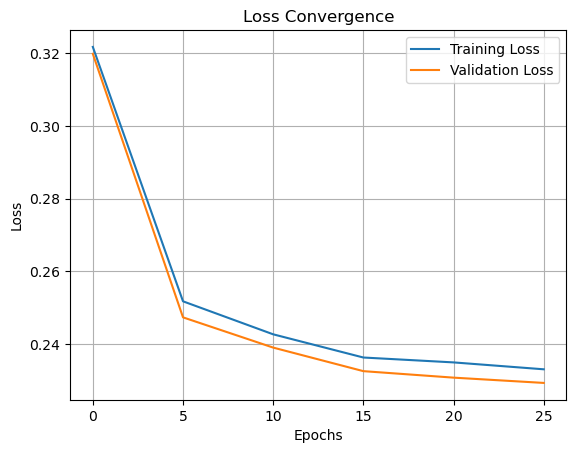

MyLSTMNet(
  (lstm): LSTM(1, 6, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=6, out_features=6, bias=True)
)
The model has 594 trainable parameters
Epoch 1: train loss 0.2998, val loss 0.3015
Epoch 6: train loss 0.2348, val loss 0.2367
Epoch 11: train loss 0.2305, val loss 0.2325
Epoch 16: train loss 0.2284, val loss 0.2300
Epoch 21: train loss 0.2190, val loss 0.2197
Epoch 26: train loss 0.2147, val loss 0.2157


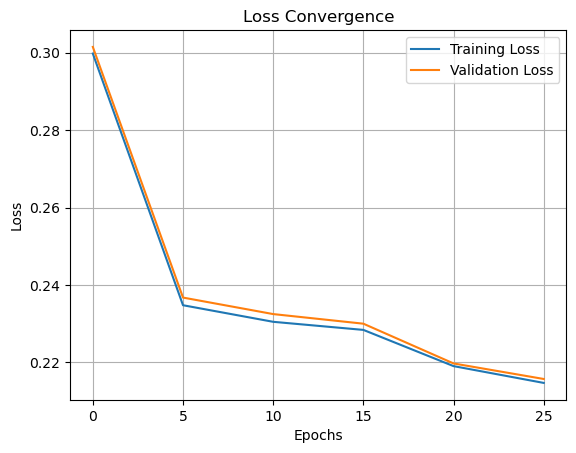

MyLSTMNet(
  (lstm): LSTM(1, 8, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=8, out_features=6, bias=True)
)
The model has 982 trainable parameters
Epoch 1: train loss 0.2782, val loss 0.2805
Epoch 6: train loss 0.2266, val loss 0.2281
Epoch 11: train loss 0.2240, val loss 0.2259
Epoch 16: train loss 0.2125, val loss 0.2161
Epoch 21: train loss 0.2108, val loss 0.2150
Epoch 26: train loss 0.2112, val loss 0.2150


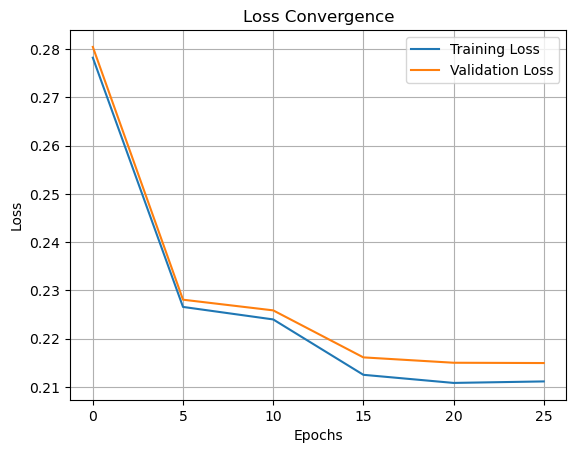

MyLSTMNet(
  (lstm): LSTM(1, 10, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=10, out_features=6, bias=True)
)
The model has 1,466 trainable parameters
Epoch 1: train loss 0.2658, val loss 0.2693
Epoch 6: train loss 0.2219, val loss 0.2279
Epoch 11: train loss 0.2176, val loss 0.2238
Epoch 16: train loss 0.2151, val loss 0.2202
Epoch 21: train loss 0.2133, val loss 0.2198
Epoch 26: train loss 0.2079, val loss 0.2136


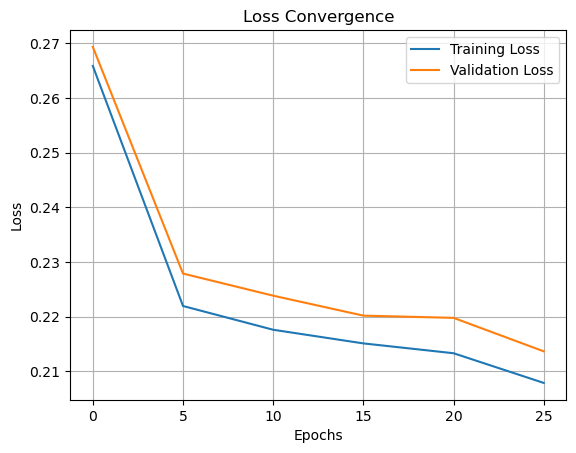

In [43]:
num_features = X_10.shape[2]
hidden_layer_sizes = [4, 6, 8, 10]
output_size = test_steps
num_layers = 2
dropout_prob = 0.2
n_epochs = 26
lr = 0.001

for hidden_layer_size in hidden_layer_sizes:
    model_lstm = MyLSTMNet(num_features, hidden_layer_size, num_layers, output_size,dropout_prob)

    print(model_lstm)

    train_loss_history_10,val_loss_history_10, model_lstm = train_predict_model(model_lstm, n_epochs, 
                                                                            lr, X_10, y_6, lenghts_10,
                                                                            validation_split=0.2)
    vis_train_loss(train_loss_history_10, val_loss_history_10)
    

MyLSTMNet(
  (lstm): LSTM(1, 4, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=4, out_features=6, bias=True)
)
The model has 142 trainable parameters
Epoch 1: train loss 0.3045, val loss 0.3104
Epoch 6: train loss 0.2555, val loss 0.2621
Epoch 11: train loss 0.2437, val loss 0.2526
Epoch 16: train loss 0.2416, val loss 0.2497
Epoch 21: train loss 0.2387, val loss 0.2473
Epoch 26: train loss 0.2377, val loss 0.2455


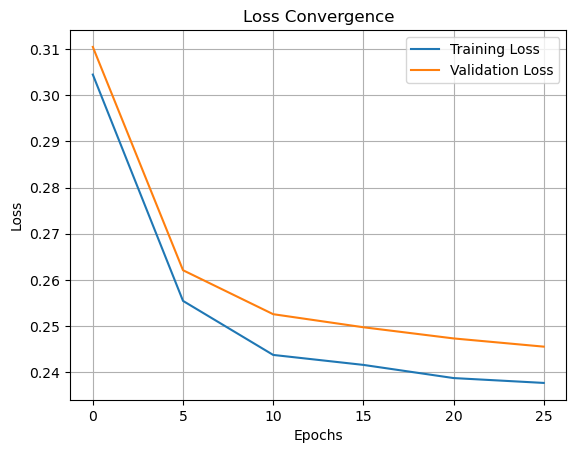

MyLSTMNet(
  (lstm): LSTM(1, 6, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=6, out_features=6, bias=True)
)
The model has 258 trainable parameters
Epoch 1: train loss 0.2936, val loss 0.2938
Epoch 6: train loss 0.2409, val loss 0.2432
Epoch 11: train loss 0.2353, val loss 0.2371
Epoch 16: train loss 0.2353, val loss 0.2371
Epoch 21: train loss 0.2365, val loss 0.2380
Epoch 26: train loss 0.2333, val loss 0.2352


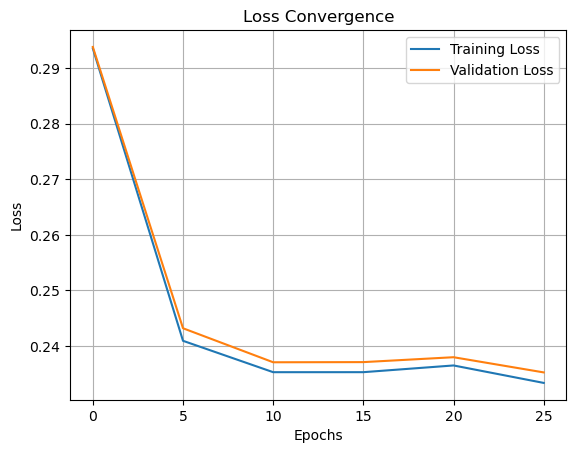

MyLSTMNet(
  (lstm): LSTM(1, 8, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=8, out_features=6, bias=True)
)
The model has 406 trainable parameters
Epoch 1: train loss 0.2908, val loss 0.2917
Epoch 6: train loss 0.2395, val loss 0.2439
Epoch 11: train loss 0.2337, val loss 0.2386
Epoch 16: train loss 0.2308, val loss 0.2364
Epoch 21: train loss 0.2293, val loss 0.2350
Epoch 26: train loss 0.2262, val loss 0.2332


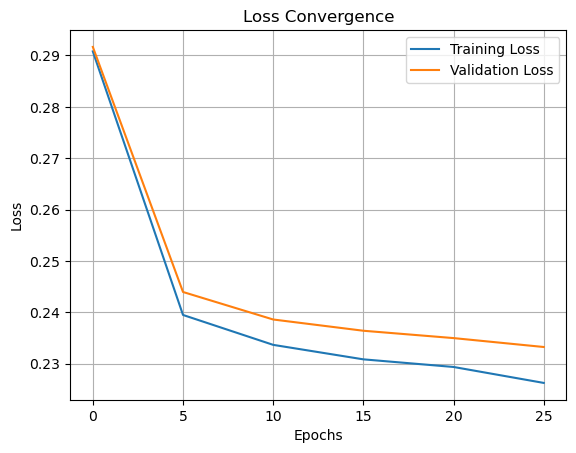

MyLSTMNet(
  (lstm): LSTM(1, 10, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=10, out_features=6, bias=True)
)
The model has 586 trainable parameters
Epoch 1: train loss 0.2822, val loss 0.2848
Epoch 6: train loss 0.2316, val loss 0.2364
Epoch 11: train loss 0.2289, val loss 0.2328
Epoch 16: train loss 0.2259, val loss 0.2299
Epoch 21: train loss 0.2224, val loss 0.2254
Epoch 26: train loss 0.2160, val loss 0.2197


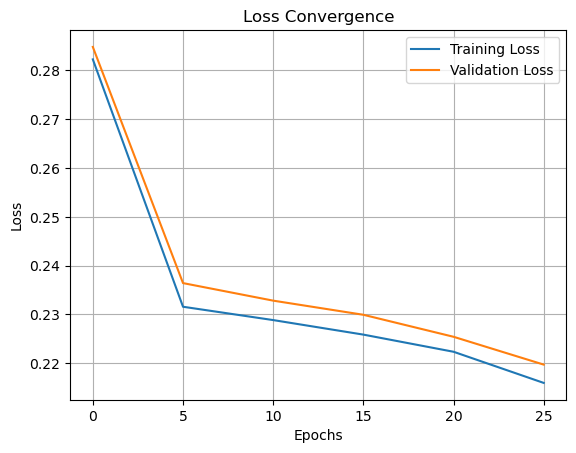

In [45]:
num_features = X_10.shape[2]
hidden_layer_sizes = [4, 6, 8, 10]
output_size = test_steps
num_layers = 1
dropout_prob = 0.2
n_epochs = 26
lr = 0.001

for hidden_layer_size in hidden_layer_sizes:
    model_lstm = MyLSTMNet(num_features, hidden_layer_size, num_layers, output_size,dropout_prob)

    print(model_lstm)

    train_loss_history_10,val_loss_history_10, model_lstm = train_predict_model(model_lstm, n_epochs, 
                                                                            lr, X_10, y_6, lenghts_10,
                                                                            validation_split=0.2)
    vis_train_loss(train_loss_history_10, val_loss_history_10)
    

# Training the Univariate LSTM Model

In [47]:
# Optimal parameter

n_epochs = 25
lr = 0.001
num_features = X_10.shape[2]
hidden_layer_size = 10
output_size = test_steps
num_layers = 2
dropout_prob = 0.2

train_loss_history_10,val_loss_history_10, model_lstm = train_predict_model(model_lstm, n_epochs, 
                                                                            lr, X_10, y_6, lenghts_10,
                                                                            validation_split=0.2)

The model has 586 trainable parameters
Epoch 1: train loss 0.2151, val loss 0.2188
Epoch 6: train loss 0.2127, val loss 0.2171
Epoch 11: train loss 0.2122, val loss 0.2165
Epoch 16: train loss 0.2109, val loss 0.2155
Epoch 21: train loss 0.2120, val loss 0.2177


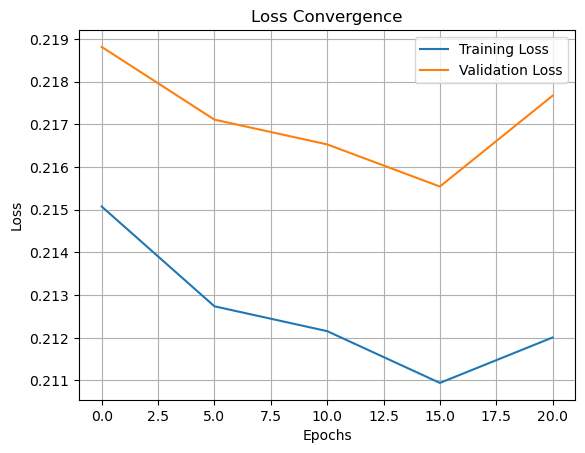

In [49]:
vis_train_loss(train_loss_history_10, val_loss_history_10)

# Computing RSME

In [50]:
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score
def pred_eval(model, X, y, lengths, train_d, test_d, lookback, target_col):
    model.eval()
    with torch.no_grad():
        train_preds = model(X, lengths)
        print("Training RMSE:",root_mean_squared_error(y.flatten().tolist(),train_preds.flatten().tolist()))
        print("Training R2:", r2_score(y.flatten().tolist(),train_preds.flatten().tolist()))
        X_test = []
        y_test = []
        lengths_test = []
        for count, (location_id, test_values, scaler) in enumerate(test_d):
            train_values = train_d[count][1]
            X_test.append(train_values[-lookback:])
            y_test.append(test_values[:,target_col])
            # Append the actual lengths (just like the training phase)
            lengths_test.append(len(train_values[-lookback:]))  
        X_test = torch.Tensor(np.array(X_test)) 
        y_test = torch.Tensor(np.array(y_test))
        lengths_test = torch.Tensor(lengths_test).long()
        test_preds = model(X_test,lengths_test)
        #print(y_test.flatten().tolist())
        #print(test_preds.flatten().tolist())
        print("Test RMSE:",root_mean_squared_error(y_test.flatten().tolist(),test_preds.flatten().tolist()))
        print("Test R2:", r2_score(y_test.flatten().tolist(),test_preds.flatten().tolist()))
        plt.figure(figsize=(10, 6))
        plt.plot(y_test.flatten().tolist(), label="Expected Value")
        plt.plot(test_preds.flatten().tolist(), label="Predicted Value")
        plt.grid()
        plt.legend(fontsize=10)
        plt.tight_layout()
        plt.show()

Training RMSE: 0.45911405179648146
Training R2: 0.7918068651240849
Test RMSE: 0.4672163320902672
Test R2: -0.01622803459116806


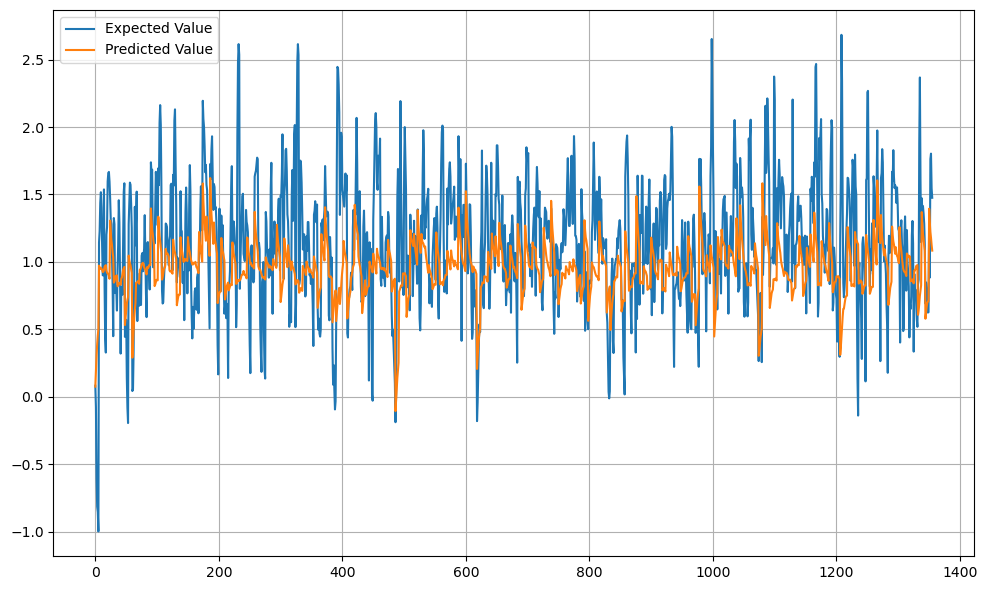

In [51]:
lookback = 10
target_col = 0
pred_eval(model_lstm, X_10, y_6, lenghts_10, train_d_10, test_d_10, lookback, target_col)

## Second Univariate LSTM model

In [52]:
lookback = 20
test_steps = 6
target_col = 0
X_20, y_6, lenghts_20, train_d_20, test_d_20 = data_prep(df,['TSDM'],lookback,test_steps, target_col)

print("Shape of input data after sequence creation:", X_20.shape)
print("Shape of targets after sequence creation:", y_6.shape)

Shape of input data after sequence creation: torch.Size([29606, 20, 1])
Shape of targets after sequence creation: torch.Size([29606, 6])


In [53]:
num_features = X_20.shape[2]
hidden_layer_size = 10
output_size = test_steps
num_layers = 2
dropout_prob = 0.2

model_lstm_20 = MyLSTMNet(num_features, hidden_layer_size, num_layers, output_size,dropout_prob)
print(model_lstm_20)

MyLSTMNet(
  (lstm): LSTM(1, 10, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=10, out_features=6, bias=True)
)


In [54]:
n_epochs = 25
lr = 0.001 #learning rate
train_loss_history_20,val_loss_history_20, model_lstm_20 = train_predict_model(model_lstm_20, n_epochs, 
                                                                            lr, X_20, y_6, lenghts_20,
                                                                            validation_split=0.2)

The model has 1,466 trainable parameters
Epoch 1: train loss 0.2677, val loss 0.2562
Epoch 6: train loss 0.2081, val loss 0.1992
Epoch 11: train loss 0.2007, val loss 0.1929
Epoch 16: train loss 0.1960, val loss 0.1886
Epoch 21: train loss 0.1947, val loss 0.1868


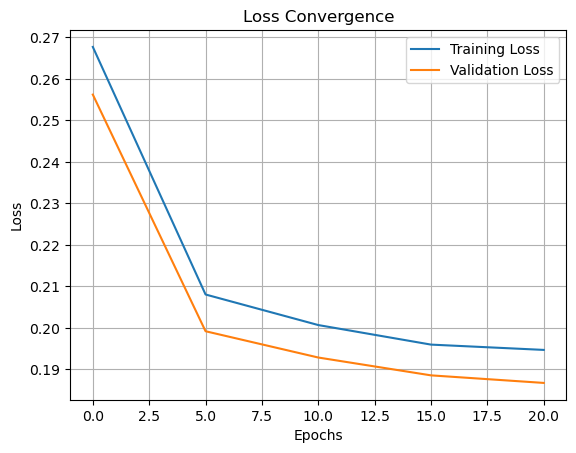

In [55]:
vis_train_loss(train_loss_history_20, val_loss_history_20)

Training RMSE: 0.4365375018723935
Training R2: 0.8117788805652445
Test RMSE: 0.5385349857149115
Test R2: -0.3501529975182325


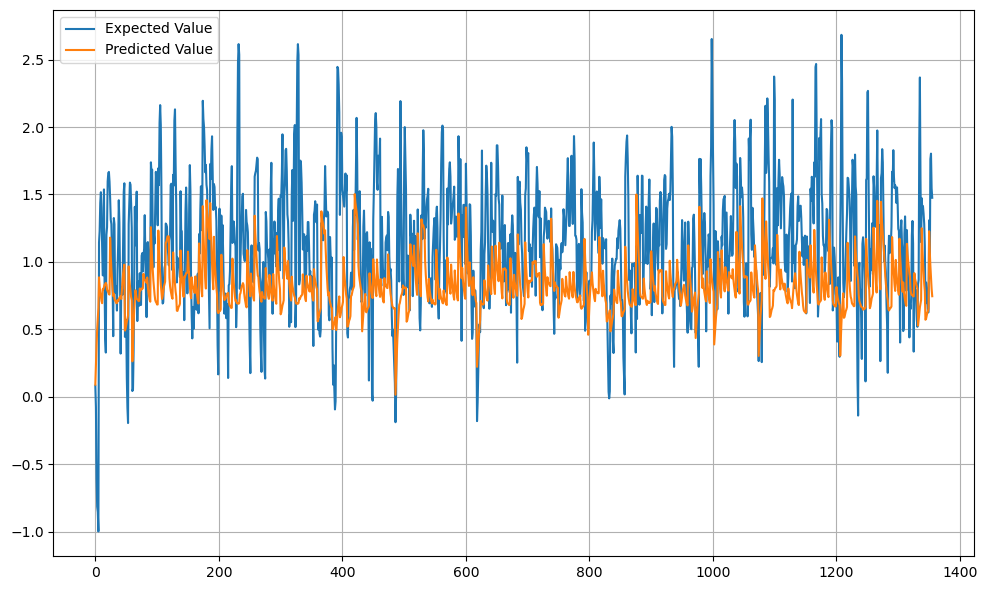

In [56]:
lookback = 20
target_col = 0
pred_eval(model_lstm_20, X_20, y_6, lenghts_20, train_d_20, test_d_20, lookback, target_col)

## Multivariate LSTM model without lookback restrictions

In [57]:
import numpy as np
import torch
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence

def create_sequences(sequence, lookback, forecast_horizon, target_col, pad_value=0.0):
    T, num_features = sequence.shape
    X, y, lengths = [], [], []

    if lookback > 0:
        # Fixed-length lookback with pre-padding
        pad_vector = np.zeros((lookback, num_features))

        for t in range(1, T - forecast_horizon + 1):
            context = sequence[:t]
            if len(context) > lookback:
                context = context[-lookback:]

            padded_context = pad_vector.copy()
            padded_context[-len(context):] = context

            X.append(padded_context)
            y.append(sequence[t:t + forecast_horizon, target_col])
            lengths.append(min(len(context), lookback))

        return np.array(X), np.array(y), lengths

    else:
        # Full history with left pre-padding (variable-length inputs)
        for t in range(1, T - forecast_horizon + 1):
            context = torch.tensor(sequence[:t], dtype=torch.float32)
            lengths.append(t)

            X.append(context)  # No manual padding
            y.append(torch.tensor(sequence[t:t + forecast_horizon, target_col], dtype=torch.float32))

        X_padded = pad_sequence(X, batch_first=True, padding_value=pad_value)
        y_tensor = torch.stack(y)

        return X_padded.numpy(), y_tensor.numpy(), lengths

Shape of input data after sequence creation: torch.Size([29606, 131, 8])
Shape of targets after sequence creation: torch.Size([29606, 6])
The model has 1,746 trainable parameters
Epoch 1: train loss 0.1873, val loss 0.1822
Epoch 6: train loss 0.1304, val loss 0.1283
Epoch 11: train loss 0.1246, val loss 0.1229
Epoch 16: train loss 0.1232, val loss 0.1216
Epoch 21: train loss 0.1212, val loss 0.1198


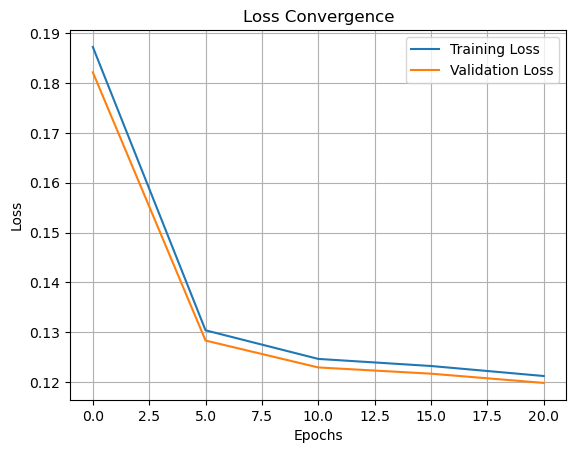

Training RMSE: 0.3453776072688578
Training R2: 0.8821814734055708
Test RMSE: 0.6905850607894681
Test R2: -1.2201867098803714


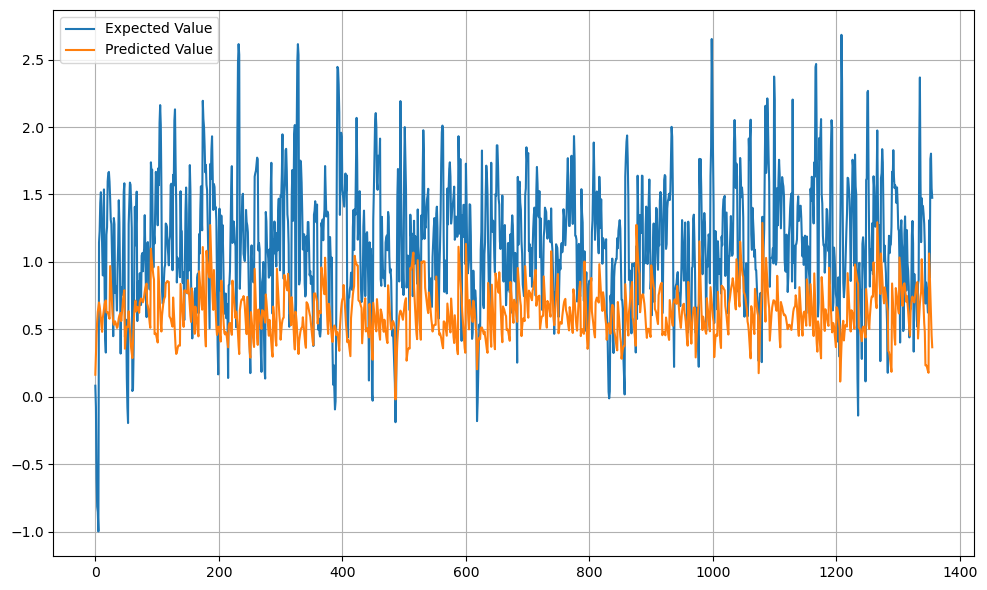

In [58]:
lookback = 0 # Means no restriction of lookback
target_col = 0

X_f, y_f,lengths_f, train_d_f, test_d_f = data_prep(df,['TSDM', '15D_AVG_DAILY_RAIN', '15D_AVG_MAX_TEMP','15D_AVG_MIN_TEMP', '15D_AVG_RH_TMAX', '15D_AVG_RH_TMIN', '15D_AVG_EVAP_SYN','15D_AVG_RADIATION'],lookback,test_steps, target_col)
print("Shape of input data after sequence creation:", X_f.shape)
print("Shape of targets after sequence creation:", y_f.shape)

num_features = X_f.shape[2]
hidden_layer_size = 10
output_size = test_steps
n_epochs = 25
lr = 0.001
num_layers = 2
dropout_prob = 0.2

model_lstm_f = MyLSTMNet(num_features, hidden_layer_size, num_layers, output_size,dropout_prob)

train_loss_history_f,val_loss_history_f,model_lstm_f = train_predict_model(model_lstm_f, n_epochs, 
                                                                           lr, X_f, y_f, lengths_f, 
                                                                           validation_split=0.2)

vis_train_loss(train_loss_history_f, val_loss_history_f)

pred_eval(model_lstm_f, X_f, y_f, lengths_f, train_d_f, test_d_f, lookback, target_col)

In [71]:
print(model_lstm_f)

MyLSTMNet(
  (lstm): LSTM(8, 10, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=10, out_features=6, bias=True)
)
